In [1]:
import skimage
import os
import sys
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import argparse
import cv2
from scipy import io
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
from pytorch_msssim import ssim

sys.path.insert(0, os.path.abspath('..'))
import utils
from incode_experiments import utils as incode_utils
from incode_experiments.models import INR
from incode_experiments import dataio

In [169]:
parser = argparse.ArgumentParser(description='LG_INCODE')

# Shared Parameters
parser.add_argument('--input', type=str, default='../data/DIV2K/superresolution/0882.png', help='Input image path')
parser.add_argument('--inr_model', type=str, default='lg_incode', help='[incode, lg_incode, lc_incode]')
parser.add_argument('--lr',type=float, default=9e-4, help='Learning rate')
parser.add_argument('--using_schedular', type=bool, default=True, help='Whether to use schedular')
parser.add_argument('--scheduler_b', type=float, default=0.1, help='Learning rate scheduler')
parser.add_argument('--maxpoints', type=int, default=256*256, help='Batch size')
parser.add_argument('--niters', type=int, default=2001, help='Number if iterations')
parser.add_argument('--steps_til_summary', type=int, default=100, help='Number of steps till summary visualization')
parser.add_argument('--upscale_factor', type=int, default=4, help='Upscale factor for super-resolution (e.g., 4x larger output)')
parser.add_argument('--eval_epoch', type=int, default=500, help='HR evaluation epoch')
parser.add_argument('--downsample', type=int, nargs='+', default=(6, 8), help='Partition factors for Local-Global INCODE')

# INCODE Parameters
parser.add_argument('--a_coef',type=float, default=0.1993, help='a coeficient')
parser.add_argument('--b_coef',type=float, default=0.0196, help='b coeficient')
parser.add_argument('--c_coef',type=float, default=0.0588, help='c coeficient')
parser.add_argument('--d_coef',type=float, default=0.0269, help='d coeficient')

args = parser.parse_args(args=[])

groups = np.prod(args.downsample) if 'lg' in args.inr_model or 'lc' in args.inr_model else 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Data

In [170]:
im_hr = incode_utils.normalize(plt.imread(args.input).astype(np.float32), True)
im_hr = im_hr[:-(im_hr.shape[0] % (args.upscale_factor * args.downsample[0])), :-(im_hr.shape[1] % (args.upscale_factor * args.downsample[1])), :]
im_lr = cv2.resize(im_hr, None, fx=1/args.upscale_factor, fy=1/args.upscale_factor, interpolation=cv2.INTER_AREA)

H_hr, W_hr, _ = im_hr.shape
H_lr, W_lr, _ = im_lr.shape

## Defining Model

### Model Configurations

In [173]:
### Harmonizer Configurations
MLP_configs={'task': 'image',
             'model': 'resnet34',
             'truncated_layer':5,
             'in_channels': 64,             
             'hidden_channels': [64, 32, 12] if args.inr_model == 'lg_incode' else [64, 32, 4],
             'mlp_bias':0.3120,
             'activation_layer': nn.SiLU,
             'GT': torch.tensor(im_lr).to(device)[None,...].permute(0, 3, 1, 2)
            }

### Model Configurations
if 'lc_' in args.inr_model:
    additional_kwargs = {'groups': np.prod(args.downsample), 'hidden_features': 36 * 6 * 8}
elif 'lg_' in args.inr_model:
    additional_kwargs = {'groups': np.prod(args.downsample), 'hidden_features': 34 * 6 * 8, 'global_hidden_features': 68}
else:
    additional_kwargs = {'hidden_features': 256}

model = INR(args.inr_model).run(in_features=2,
                                out_features=3, 
                                hidden_layers=3,
                                first_omega_0=30.0,
                                hidden_omega_0=30.0,
                                pos_encode_configs={'type': None}, 
                                MLP_configs = MLP_configs,
                                **additional_kwargs
                               ).to(device)

In [174]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

if args.inr_model == 'lg_incode':
    print('Total Params:', count_parameters(model.global_net) + count_parameters(model.net) + count_parameters(model.agg_func) + count_parameters(model.aux_mlp))
    print('Global Params:', count_parameters(model.global_net) + count_parameters(model.agg_func) + count_parameters(model.aux_mlp))
    print('Local Params:', count_parameters(model.net))
elif 'incode' in args.inr_model:
    print('Total Params', count_parameters(model.net) + count_parameters(model.aux_mlp))

Total Params: 205714
Global Params: 24418
Local Params: 181296


## Training Code

In [175]:
if args.inr_model == 'lg_incode':
    optim = torch.optim.Adam([{'params': [p[1] for p in model.named_parameters() if 'feature_extractor' not in p[0] and 'global' not in p[0]], 'lr': args.lr}, 
                                {'params': [p[1] for p in model.named_parameters() if 'global' in p[0]], 'lr': args.lr / 1.8}], lr=args.lr)
else:
    optim = torch.optim.Adam(lr=args.lr, params=[p[1] for p in model.named_parameters() if 'feature_extractor' not in p[0]])

scheduler = lr_scheduler.LambdaLR(optim, lambda x: args.scheduler_b ** min(x / args.niters, 1))

psnr_values_lr = []
psnr_values_hr = []
ssim_values_hr = []
mse_array = torch.zeros(args.niters, device=device)

# Initialize best loss value as positive infinity
best_loss = torch.tensor(float('inf'))

In [176]:
image_lr_dataset = dataio.ImageFileFromArray(im_lr)
image_lr_dataset = dataio.ImplicitSingle2DWrapper(image_lr_dataset, downsample=tuple(args.downsample) if 'lg' in args.inr_model or 'lc' in args.inr_model else None, n_samples=args.maxpoints)

image_hr_dataset = dataio.ImageFileFromArray(im_hr)
image_hr_dataset = dataio.ImplicitSingle2DWrapper(image_hr_dataset, downsample=tuple(args.downsample) if 'lg' in args.inr_model or 'lc' in args.inr_model else None)

image_lr_dataloader = DataLoader(image_lr_dataset, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)
image_hr_dataloader = DataLoader(image_hr_dataset, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)

  0%|          | 0/2001 [00:00<?, ?it/s]

Epoch: 0 | Total Loss: 0.26239 | PSNR LR: 5.8105
Epoch: 100 | Total Loss: 0.00235 | PSNR LR: 26.2836
Epoch: 200 | Total Loss: 0.00127 | PSNR LR: 28.9585
Epoch: 300 | Total Loss: 0.00098 | PSNR LR: 30.1014
Epoch: 400 | Total Loss: 0.00071 | PSNR LR: 31.4765
Epoch: 500 | Total Loss: 0.00057 | PSNR LR: 32.4608


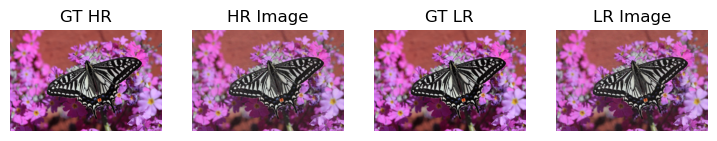

Epoch: 600 | Total Loss: 0.00040 | PSNR LR: 33.9685 | PSNR HR: 28.7561 | SSIM: 0.8836


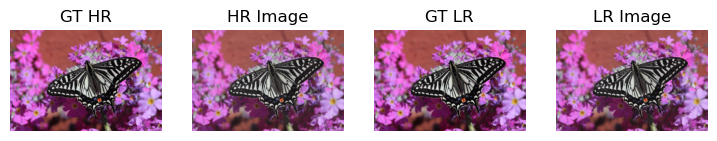

Epoch: 700 | Total Loss: 0.00033 | PSNR LR: 34.8107 | PSNR HR: 29.0510 | SSIM: 0.8884


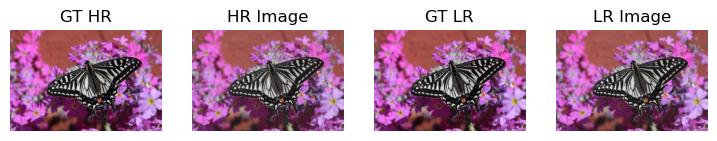

Epoch: 800 | Total Loss: 0.00029 | PSNR LR: 35.3331 | PSNR HR: 29.1647 | SSIM: 0.8907


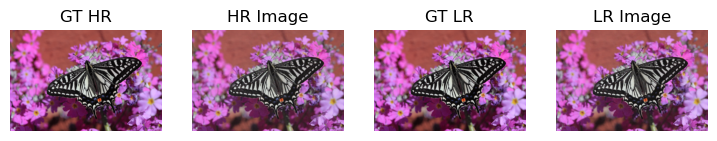

Epoch: 900 | Total Loss: 0.00025 | PSNR LR: 35.9682 | PSNR HR: 29.3282 | SSIM: 0.8934


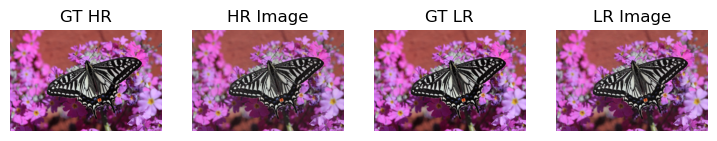

Epoch: 1000 | Total Loss: 0.00021 | PSNR LR: 36.8727 | PSNR HR: 29.5609 | SSIM: 0.8966


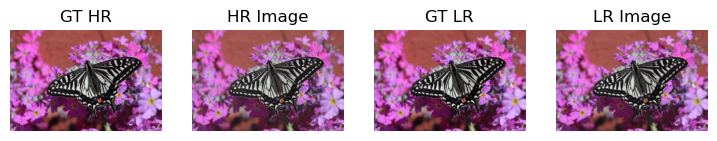

Epoch: 1100 | Total Loss: 0.00019 | PSNR LR: 37.2986 | PSNR HR: 29.6115 | SSIM: 0.8978


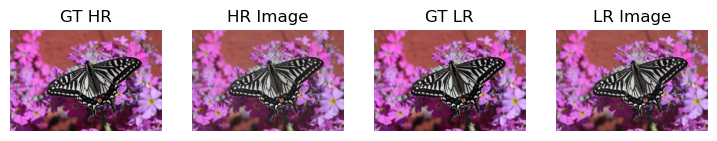

Epoch: 1200 | Total Loss: 0.00017 | PSNR LR: 37.7721 | PSNR HR: 29.7303 | SSIM: 0.8992
Epoch: 1300 | Total Loss: 0.00015 | PSNR LR: 38.1430 | PSNR HR: 29.7200 | SSIM: 0.8998


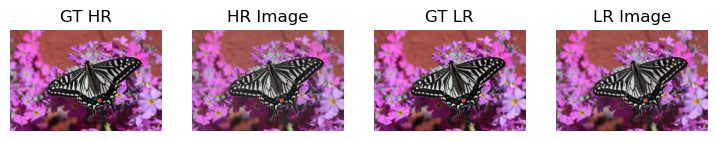

Epoch: 1400 | Total Loss: 0.00014 | PSNR LR: 38.4975 | PSNR HR: 29.8139 | SSIM: 0.9010


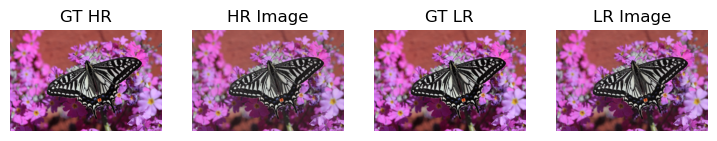

Epoch: 1500 | Total Loss: 0.00013 | PSNR LR: 38.8118 | PSNR HR: 29.8905 | SSIM: 0.9018
Epoch: 1600 | Total Loss: 0.00012 | PSNR LR: 39.0687 | PSNR HR: 29.8856 | SSIM: 0.9023


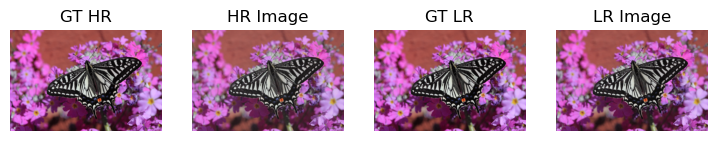

Epoch: 1700 | Total Loss: 0.00012 | PSNR LR: 39.3640 | PSNR HR: 29.9634 | SSIM: 0.9031


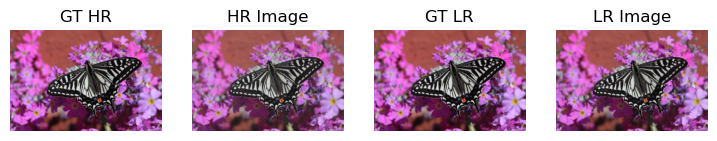

Epoch: 1800 | Total Loss: 0.00011 | PSNR LR: 39.5620 | PSNR HR: 29.9681 | SSIM: 0.9033


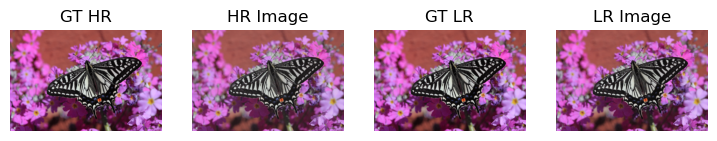

Epoch: 1900 | Total Loss: 0.00011 | PSNR LR: 39.7067 | PSNR HR: 29.9836 | SSIM: 0.9037


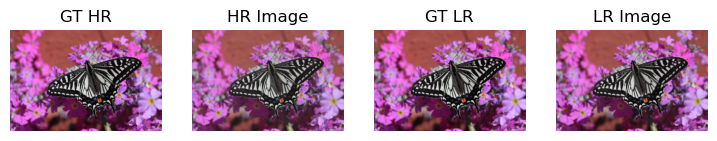

Epoch: 2000 | Total Loss: 0.00010 | PSNR LR: 39.8853 | PSNR HR: 29.9974 | SSIM: 0.9040
--------------------
Max PSNR LR: 39.88526916503906
Max PSNR HR: 29.997394561767578
--------------------


In [177]:
for step in tqdm(range(args.niters)):
    for in_dict, gt_dict in image_lr_dataloader:
        b_coords = in_dict['coords'].cuda()
        
        # Calculate model output
        if 'incode' in args.inr_model:
            model_output, coef = model(b_coords)  
        else:
            model_output = model(b_coords) 

        # Calculate the output loss
        output_loss = ((model_output - gt_dict['img'].cuda())**2).mean()
        
        if 'incode' in args.inr_model:
            # Calculate regularization loss for 'incode' model
            all_coeffs = []
            for i in range(0, len(coef[0]), 4):
                all_coeffs.append(coef[0][i:i+4])
            
            reg_loss = args.a_coef * torch.relu(-all_coeffs[0][0]) + \
                       args.b_coef * torch.relu(-all_coeffs[0][1]) + \
                       args.c_coef * torch.relu(-all_coeffs[0][2]) + \
                       args.d_coef * torch.relu(-all_coeffs[0][3])
            
            for coeffs in all_coeffs[1:]:
                reg_loss += args.a_coef * torch.relu(-coeffs[0]) + \
                           args.b_coef * torch.relu(-coeffs[1]) + \
                           args.c_coef * torch.relu(-coeffs[2]) + \
                           args.d_coef * torch.relu(-coeffs[3])

            # Total loss for 'incode' model
            loss = output_loss + reg_loss
        else:
            # Total loss for other models
            loss = output_loss

        # Perform backpropagation and update model parameters
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    
    # Calculate and log mean squared error (MSE) and PSNR
    with torch.no_grad():
        # Display intermediate results at specified intervals
        if (step % args.steps_til_summary == 0):
            if 'incode' in args.inr_model:
                model_output, _ = model(in_dict['all_coords'].cuda())
            else:
                model_output = model(in_dict['all_coords'].cuda())
            
            
            # Prepare reconstructed image for visualization
            pred_img = dataio.lin2img(model_output, (H_lr, W_lr), image_lr_dataset.gt_slices).cuda().squeeze().permute(1, 2, 0)
            gt_img = gt_dict['raw_img'].cuda().squeeze()
            
            mse_array[step] = ((gt_img - pred_img)**2).mean().item()
            psnr_lr = -10*torch.log10(mse_array[step])
            psnr_values_lr.append(psnr_lr.item())
            
            if step <= args.eval_epoch:
                print("Epoch: {} | Total Loss: {:.5f} | PSNR LR: {:.4f}".format(step, 
                                                                                 mse_array[step].item(),
                                                                                 psnr_lr.item())) 
            #### HR Evaluation
            if step > args.eval_epoch:
                in_hr_dict, gt_hr_dict = next(iter(image_hr_dataloader))
                model_output = []

                for i in range(0, H_hr * W_hr // groups, args.maxpoints // groups):
                    b_coords_hr = in_hr_dict['coords'][..., i: i+args.maxpoints // groups, :].to(device)
                    # b_coords_hr = coords_hr[:, b_indices_hr, ...].to(device)
                    # b_indices_hr = b_indices_hr.to(device)

                    if 'incode' in args.inr_model:
                        model_eval, _ = model(b_coords_hr)  
                    else:
                        model_eval = model(b_coords_hr) 

                    model_output.append(model_eval)
                
                if len(model_output[0].shape) > 3:
                    model_output = torch.hstack([x.squeeze(0) for x in model_output]).unsqueeze(0)
                else:
                    model_output = torch.hstack(model_output)

                 # Prepare reconstructed image for visualization
                pred_hr_img = dataio.lin2img(model_output, (H_hr, W_hr), image_hr_dataset.gt_slices).cuda().squeeze().permute(1, 2, 0)
                gt_hr_img = gt_hr_dict['raw_img'].cuda().squeeze()

                loss_hr = ((gt_hr_img - pred_hr_img)**2).mean()
                psnr_hr = -10*torch.log10(loss_hr)
                psnr_values_hr.append(psnr_hr.item())
                # hr_pred = rec_hr[0, ...].reshape(H_hr, W_hr, 3).detach().cpu().numpy()
                hr_pred = pred_hr_img.detach().cpu().numpy()
                hr_pred = (hr_pred - hr_pred.min()) / (hr_pred.max() - hr_pred.min())

                # Check if the current iteration's HR image is the best so far
                if (loss_hr < best_loss) or (step == args.eval_epoch+1):
                    best_loss = loss_hr
                    best_img_hr = hr_pred
                    best_img_lr = pred_img.detach().cpu().numpy()
                    best_img_lr = (best_img_lr - best_img_lr.min()) / (best_img_lr.max() - best_img_lr.min())

                    ### Plot
                    fig, axes = plt.subplots(1, 4, figsize=(9, 9))
                    subplot_info = [
                        {'title': 'GT HR', 'image': im_hr},
                        {'title': 'HR Image', 'image': best_img_hr},
                        {'title': 'GT LR', 'image': im_lr},
                        {'title': 'LR Image', 'image': best_img_lr}
                    ]

                    for ax, info in zip(axes, subplot_info):
                        ax.set_title(info['title'])
                        ax.imshow(info['image'], cmap='gray')
                        ax.axis('off')
                    plt.show()


                # SSIM
                # ms_ssim_val = ssim(torch.tensor(im_hr[None,...]).permute(0, 3, 1, 2),
                #                     torch.tensor(hr_pred[None, ...]).permute(0, 3, 1, 2),
                #                     data_range=1, size_average=False)
                ms_ssim_val = ssim(gt_hr_img.unsqueeze(0).permute(0, 3, 2, 1),
                                    pred_hr_img.unsqueeze(0).permute(0, 3, 2, 1),
                                    data_range=1, size_average=False)
                ssim_values_hr.append(ms_ssim_val[0].item())

                # Display intermediate results at specified intervals
                print("Epoch: {} | Total Loss: {:.5f} | PSNR LR: {:.4f} | PSNR HR: {:.4f} | SSIM: {:.4f}".format(step, 
                                                                                                      mse_array[step].item(),
                                                                                                      psnr_lr.item(),
                                                                                                      psnr_hr.item(),
                                                                                                      ms_ssim_val[0].item())) 

    
    # Adjust learning rate using a scheduler if applicable
    if args.using_schedular:
        scheduler.step()

        
# Print maximum PSNR achieved during training
print('--------------------')
print('Max PSNR LR:', max(psnr_values_lr))
print('Max PSNR HR:', max(psnr_values_hr))
print('--------------------')

# Convergance Rate

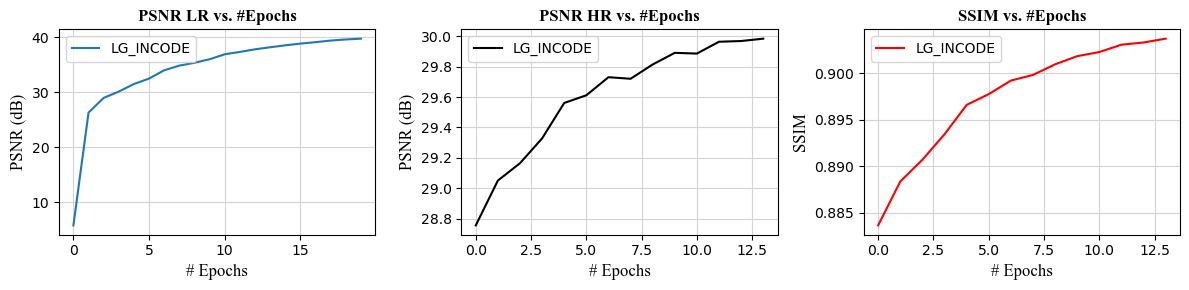

In [179]:
# Define the font settings
font = {'font': 'Times New Roman', 'size': 12}
axfont = {'family': 'Times New Roman', 'weight': 'regular', 'size': 10}

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Plot PSNR LR vs. #Epochs
axes[0].plot(np.arange(len(psnr_values_lr[:-1])), psnr_values_lr[:-1], label=f"{(args.inr_model).upper()}")
axes[0].set_xlabel('# Epochs', fontdict=font)
axes[0].set_ylabel('PSNR (dB)', fontdict=font)
axes[0].set_title('PSNR LR vs. #Epochs', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
axes[0].legend()
axes[0].grid(True, color='lightgray')

# Plot PSNR HR vs. #Epochs
axes[1].plot(np.arange(len(psnr_values_hr[:-1])), psnr_values_hr[:-1], label=f"{(args.inr_model).upper()}", color='black')
axes[1].set_xlabel('# Epochs', fontdict=font)
axes[1].set_ylabel('PSNR (dB)', fontdict=font)
axes[1].set_title('PSNR HR vs. #Epochs', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
axes[1].legend()
axes[1].grid(True, color='lightgray')

# Plot SSIM vs. #Epochs
axes[2].plot(np.arange(len(ssim_values_hr[:-1])), ssim_values_hr[:-1], label=f"{(args.inr_model).upper()}", color='red')
axes[2].set_xlabel('# Epochs', fontdict=font)
axes[2].set_ylabel('SSIM', fontdict=font)
axes[2].set_title('SSIM vs. #Epochs', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
axes[2].legend()
axes[2].grid(True, color='lightgray')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()